In [ ]:
import sys
import os

In [97]:
import pandas as pd
import numpy as np

In [99]:
DATA_DIR = 'input_path'

In [100]:
EXP_DIR = 'output_path'

In [101]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), header=0)
train_df['type'] = 'train'

In [102]:
validation_tr_df = pd.read_csv(os.path.join(DATA_DIR, 'validation_tr.csv'), header=0)
validation_tr_df['type'] = 'validation'

In [103]:
test_tr_df = pd.read_csv(os.path.join(DATA_DIR, 'test_tr.csv'), header=0)
test_tr_df['type'] = 'test'

In [104]:
train_df.uid.min(), train_df.uid.max(), validation_tr_df.uid.min(), validation_tr_df.uid.max(),\
test_tr_df.uid.min(), test_tr_df.uid.max()

(0, 116676, 116677, 126676, 126677, 136676)

In [105]:
num_users = 136676 + 1

In [106]:
all_tr_df = pd.concat([train_df, validation_tr_df, test_tr_df])

In [107]:
all_tr_df.head()

,uid,sid,type
0,116149,0,train
1,116149,1,train
2,116149,2,train
3,116149,3,train
4,116149,4,train


In [108]:
validation_te_df = pd.read_csv(os.path.join(DATA_DIR, 'validation_te.csv'), header = 0)

In [109]:
validation_te_df.head()

,uid,sid
0,123737,3
1,123737,135
2,120983,126
3,120983,272
4,120983,245


In [110]:
test_te_df = pd.read_csv(os.path.join(DATA_DIR, 'test_te.csv'), header = 0)

In [111]:
test_te_df.head()

,uid,sid
0,134677,239
1,134677,504
2,134677,367
3,128041,125
4,128041,235


In [112]:
show_2_id_df = pd.read_csv(os.path.join(DATA_DIR, 'show2id.txt'), names=['movieId', 'sid'])

In [113]:
num_items = show_2_id_df.sid.max() + 1
num_items
availability = np.ones(num_items, dtype=np.int32)

In [114]:
model_censored = False

In [115]:
if model_censored:
    np.random.seed(0)
    cold_start_titles = np.random.choice(pd.unique(test_te_df['sid']), 1000, replace=False)
    availability[cold_start_titles] = 0
    availability_df = pd.DataFrame({'sid' : np.arange(num_items), 'availability' : availability})
    show_2_id_df = pd.merge(show_2_id_df, availability_df, on = 'sid')
    all_tr_filtered_df = pd.merge(all_tr_df, show_2_id_df[show_2_id_df.availability == 1], on = 'sid') 
    print(all_tr_filtered_df.shape, all_tr_df.shape)
    print(pd.unique(all_tr_filtered_df.uid).shape, pd.unique(all_tr_df.uid).shape)
    pd.unique(all_tr_filtered_df.uid).shape == pd.unique(all_tr_df.uid).shape
    all_tr_df = all_tr_filtered_df

# Model 1 : With User-Video Tags; Generative model only for Video History

In [116]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [117]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import gzip
import sys

# pylint: disable=missing-docstring
import time
import tensorflow as tf
import numpy as np
from scipy import sparse
import bottleneck as bn

In [118]:
def load_all_training_data(all_tr_df, num_users, num_items):
    rows, cols = all_tr_df['uid'], all_tr_df['sid']
    all_tr_mat = sparse.csr_matrix(
        (np.ones_like(rows), (rows, cols)),
        dtype='float64',
        shape=(num_users, num_items))
    return all_tr_mat, pd.unique(all_tr_df[all_tr_df.type == 'train'].uid), pd.unique(all_tr_df[all_tr_df.type == 'validation'].uid), pd.unique(all_tr_df[all_tr_df.type == 'test'].uid) 

def load_vad_te_data(validation_te_df, num_items):
    vad_start_idx = validation_te_df['uid'].min()
    vad_end_idx = validation_te_df['uid'].max()
    rows_te, cols_te = validation_te_df['uid'] - vad_start_idx, validation_te_df['sid']
    vad_data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                 (rows_te, cols_te)),
                                dtype='float64', shape=(vad_end_idx - vad_start_idx + 1, num_items))
    return vad_data_te, pd.unique(validation_te_df.uid)

def get_video_tags_mat(num_items, num_tags, filename):
    video_tags_df = pd.read_csv(os.path.join(DATA_DIR, filename), header = 0)
    rows, cols = video_tags_df.sid, video_tags_df.genre_index
    video_tags_mat = np.zeros((num_items, num_tags))
    video_tags_mat[rows, cols] = 1
    return video_tags_mat

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [119]:
all_tr_mat, train_idxlist, validation_idxlist, test_idxlist =\
load_all_training_data(all_tr_df, num_users, num_items)

In [120]:
print(all_tr_mat.shape,train_idxlist.shape, validation_idxlist.shape, test_idxlist.shape)

(136677, 20108) (116677,) (10000,) (10000,)


In [121]:
vad_data_te, _ = load_vad_te_data(validation_te_df, num_items)
vad_start_index = validation_idxlist.min()

In [122]:
N_validation = validation_idxlist.shape[0]
print(N_validation, vad_start_index)

10000 116677


In [123]:
test_data_te, _ = load_vad_te_data(test_te_df, num_items)
test_start_index = test_idxlist.min()

In [124]:
# Genre Year Matrix
num_tags = pd.read_csv(os.path.join(DATA_DIR, 'genreyear2id.csv'), names=['genre', 'genre_index']).shape[0]
video_tags_mat = get_video_tags_mat(num_items, num_tags, 'movies_genres_year.csv')
video_tags_mat.shape, num_tags

((20108, 137), 137)

In [125]:
# User Tag Matrix
#num_tags = 37450
#video_tags_mat = get_video_tags_mat(num_items, num_tags, 'movies_tags.csv')
#video_tags_mat.shape, num_tags
#count_per_tag = video_tags_mat.sum(axis = 0)
#tag_count_df = pd.DataFrame({'tid' : np.arange(num_tags), 'count' : count_per_tag})
#new_tids = np.sort(tag_count_df[tag_count_df['count'] > 5]['tid'].values)
#video_tags_mat = video_tags_mat[np.arange(num_items)[:, np.newaxis], new_tids]
#num_tags = video_tags_mat.shape[1]

In [126]:
num_tags_per_video = video_tags_mat.sum(axis = 1)

In [127]:
num_tags_per_video

array([5., 2., 3., ..., 2., 3., 2.])

In [128]:
num_tags_per_video[num_tags_per_video == 0] = 1

In [129]:
num_tags_per_video

array([5., 2., 3., ..., 2., 3., 2.])

In [130]:
video_metadata_array = video_tags_mat / (num_tags_per_video[:, np.newaxis])

In [131]:
print(video_metadata_array.shape)
print(num_tags)

(20108, 137)
137


In [292]:
(video_tags_mat > 0).sum()

61129

In [293]:
video_tags_mat.sum()

61129.0

In [132]:
class Model1(object):
    def __init__(self, num_users, num_items, num_tags, num_factors, var_prior,
                 video_metadata_array,
                 availability_mask,
                 model_censored,
                 model_user_tags,
                 model_video_tags):
        self.num_users = num_users
        self.num_items = num_items
        self.num_tags = num_tags
        self.num_factors = num_factors
        self.var_prior = var_prior
        self.model_user_tags = model_user_tags
        self.model_video_tags = model_video_tags
        self.model_censored = model_censored
        self.video_metadata_array_const = tf.constant(video_metadata_array, dtype = tf.float32)
        self.availability_mask = tf.constant(availability_mask, dtype = tf.float32, shape=[1, num_items])
        self.construct_placeholders()
        
    def construct_placeholders(self):
        self.users_ph = tf.placeholder(dtype=tf.int32, shape=[None])
        self.played_videos_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.num_items])
        if self.model_user_tags:
            self.played_tags_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.num_tags])
    
    def construct_model_variables(self):
        self.Mu_Zu = tf.Variable(dtype=tf.float32,
                            initial_value=tf.random_normal(shape=[self.num_users, self.num_factors]), 
                            name = 'mean_latent_factors_zu')
        self.lsdev_Zu = tf.Variable(dtype=tf.float32,
                               initial_value=tf.random_normal(shape=[self.num_users, 1]), name='lsdev_Zu')

        self.Mu_Zv = tf.Variable(dtype=tf.float32,
                                 initial_value=tf.random_normal(shape=[self.num_items, self.num_factors]),
                                 name = 'mean_latent_factors_zv')
        
        self.Mu_Zt = tf.Variable(dtype=tf.float32,
                            initial_value=tf.random_normal(shape=[self.num_tags, self.num_factors]),
                            name = 'mean_latent_factors_zt')
        
        
    def compute_kl_div(self, lsdev_Zu_batch, Mu_Zu_batch):
        sdev_Zu_batch = tf.exp(lsdev_Zu_batch)
        comp1 = num_factors * (0.5 * np.log(self.var_prior) - lsdev_Zu_batch)
        comp2 = (num_factors / (2 * self.var_prior)) * (tf.pow(sdev_Zu_batch, 2))
        comp3 = (1.0 / (2 * self.var_prior)) * tf.reduce_sum(tf.pow(Mu_Zu_batch, 2), axis=1, keep_dims = True)
        comp4 = (self.num_factors / 2.0)

        return comp1 + comp2 + comp3 - comp4
        
    def construct_graph(self):
        self.construct_model_variables()
        
        Mu_Zu_batch = tf.gather(self.Mu_Zu, self.users_ph)
        lsdev_Zu_batch = tf.gather(self.lsdev_Zu, self.users_ph)
        Eps_u_ph = tf.random_normal(shape = [tf.size(self.users_ph), self.num_factors],
                                    mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name="eps")
        Zu_batch = Mu_Zu_batch + Eps_u_ph * tf.exp(lsdev_Zu_batch)
        

        if self.model_user_tags and self.model_video_tags:
            print('modeling user and video tags ...')
            Mu_Zv_hat = tf.matmul(self.video_metadata_array_const, self.Mu_Zt)
            Mu_Zu_tag_batch = tf.matmul(self.played_tags_ph, self.Mu_Zt)
            batch_logits = tf.matmul(Zu_batch + Mu_Zu_tag_batch, self.Mu_Zv + Mu_Zv_hat, transpose_b=True)
            batch_logits_validation = tf.matmul(Mu_Zu_batch + Mu_Zu_tag_batch, self.Mu_Zv + Mu_Zv_hat, transpose_b=True)
        if not self.model_user_tags and self.model_video_tags:
            print('modeling video tags ...')
            Mu_Zv_hat = tf.matmul(self.video_metadata_array_const, self.Mu_Zt)
            batch_logits = tf.matmul(Zu_batch, self.Mu_Zv + Mu_Zv_hat, transpose_b=True)
            batch_logits_validation = tf.matmul(Mu_Zu_batch, self.Mu_Zv + Mu_Zv_hat, transpose_b=True)
        if not self.model_user_tags and not self.model_video_tags:
            print('modeling no tags ...')
            batch_logits = tf.matmul(Zu_batch, self.Mu_Zv, transpose_b=True)
            batch_logits_validation = tf.matmul(Mu_Zu_batch, self.Mu_Zv, transpose_b=True)
    
        if self.model_censored:
            max_logits = tf.reduce_max(batch_logits, axis=1, keep_dims=True)
            logsum_exp_masked = max_logits +\
            tf.log(tf.reduce_sum(self.availability_mask * tf.exp(batch_logits - max_logits), axis=1, keep_dims=True) + 1e-8)

            log_softmax = batch_logits - logsum_exp_masked
        else:
            log_softmax = tf.nn.log_softmax(batch_logits)
        
        num_items_per_document = tf.reduce_sum(self.played_videos_ph, axis=1, keep_dims=True)
        
        batch_conditional_log_likelihood = tf.reduce_sum(self.played_videos_ph * log_softmax, axis = 1, keep_dims=True)
        batch_kl_div = self.compute_kl_div(lsdev_Zu_batch, Mu_Zu_batch)
        
        batch_elbo = (1.0 / num_items_per_document) * (batch_conditional_log_likelihood - batch_kl_div)
        
        avg_loss = -1 * tf.reduce_mean(batch_elbo) + reg * (tf.nn.l2_loss(self.Mu_Zv) +
                                                            tf.nn.l2_loss(self.Mu_Zt))
        
        return batch_logits, batch_logits_validation, log_softmax, avg_loss, batch_conditional_log_likelihood, batch_kl_div, num_items_per_document

In [133]:
var_prior = 1.0
lr = 4e-3
reg = 1e-9
num_factors = 100
batch_size = 1000
num_epochs = 1000
model_video_tags = True
model_user_tags = True

In [134]:
heldout_idxlist = test_idxlist
heldout_start_index = test_start_index
heldout_data_te = test_data_te

In [76]:
'''logging info'''
attempt = 2
experiment_name = 'censored-{model_censored}-testmetrics-user=id-tags-{model_user_tags}-video=id-tags-{model_video_tags}-learningrate={lr}-regularization={reg}-numfactors={num_factors}-prior_var-{prior_var}-epochs-{epochs}-attempt={attempt}'\
.format(model_censored=model_censored,model_user_tags=model_user_tags, model_video_tags=model_video_tags,
        lr=lr, reg=reg, num_factors=num_factors, attempt=attempt, prior_var = var_prior, epochs = num_epochs)

print('experiment name :', experiment_name)
print('output dir :', EXP_DIR)

!mkdir -p {os.path.join(EXP_DIR, 'logs', experiment_name)}
!mkdir -p {os.path.join(EXP_DIR, 'tensorflow_output', experiment_name)}
!mkdir -p {os.path.join(EXP_DIR, 'tensorflow_models', experiment_name)}

output_line_template = '{epoch_ind},ndcg,{ndcg_mean}+/-{ndcg_se},batch_loss,{batch_loss}'
tf.reset_default_graph()
fw = open(os.path.join(EXP_DIR, 'logs', experiment_name,'_logs.txt'), 'wb')

experiment name : censored-True-testmetrics-user=id-tags-True-video=id-tags-True-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2
output dir : /data/ml20m/ml-20m/exp20181002-final


In [77]:
tf.reset_default_graph()
with tf.Graph().as_default():
    model1 = Model1(num_users,
                    num_items,
                    num_tags,
                    num_factors,
                    var_prior,
                    video_metadata_array,
                    availability,
                    model_censored,
                    model_user_tags,
                    model_video_tags)
    batch_logits, batch_logits_validation, log_softmax, avg_loss, batch_conditional_log_likelihood,\
    batch_kl_div, num_items_per_document = model1.construct_graph()
    train_op = tf.train.AdamOptimizer(learning_rate=lr)\
    .minimize(avg_loss, global_step=tf.Variable(0, name='global_step_1', trainable=False))

    ####Tensors for validation####
    train_op_validation = tf.train.AdamOptimizer(learning_rate=lr)\
    .minimize(avg_loss,
              var_list = [model1.Mu_Zu, model1.lsdev_Zu],
              global_step=tf.Variable(0, name='global_step_1_validation', trainable=False))

    ####Summary####
    avg_loss_summary_ph = tf.placeholder(dtype = tf.float32)
    tf.summary.scalar('avg_loss', avg_loss_summary_ph)

    ndcg_summary_ph = tf.placeholder(dtype=tf.float32)
    tf.summary.scalar('ndcg_100', ndcg_summary_ph)
    summary = tf.summary.merge_all()

    ####Start####
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        summary_writer = tf.summary.FileWriter('{EXP_DIR}/tensorflow_output/{experiment_name}'.format(
            EXP_DIR = EXP_DIR,
            experiment_name = experiment_name), sess.graph)
        sess.run(init)
        ndcgs_vad = []
        best_ndcg_sofar = -1000
        for epoch_ind in np.arange(num_epochs):

            ###Optimize parameters for Validation users ####    
            avg_loss_validation = 0
            num_batches = 0
            for batch_ind, st_index in enumerate(range(0, heldout_idxlist.shape[0], batch_size)):
                batch_start_time = time.time()
                end_index = min(st_index + batch_size, heldout_idxlist.shape[0])
                user_indices = heldout_idxlist[st_index:end_index]
                X = all_tr_mat[user_indices]
                X = X.toarray()
                X = X.astype('float32')
                
                feed_dict = {model1.users_ph : user_indices,
                             model1.played_videos_ph : X}
                if model_user_tags:
                    M_u = np.dot(X, video_tags_mat)
                    M_u[M_u > 0] = 1
                    num_tags_per_user = M_u.sum(axis = 1)
                    num_tags_per_user[num_tags_per_user == 0] = 1
                    M_u = M_u / (num_tags_per_user[:, np.newaxis])
                    feed_dict[model1.played_tags_ph] = M_u
                
                _, loss_val = sess.run([train_op_validation, avg_loss], feed_dict=feed_dict)
                avg_loss_validation += loss_val
                num_batches += 1
            avg_loss_validation /= num_batches

            ####Metrics Computation####
            ndcg_dist = []
            for batch_ind, st_index in enumerate(range(0, heldout_idxlist.shape[0], batch_size)):
                end_index = min(st_index + batch_size, heldout_idxlist.shape[0])
                heldout_user_indices = heldout_idxlist[st_index:end_index]
                X = all_tr_mat[heldout_user_indices]
                X = X.toarray()
                X = X.astype('float32')
                feed_dict = {model1.users_ph : heldout_user_indices}
                if model_user_tags:
                    M_u = np.dot(X, video_tags_mat)
                    M_u[M_u > 0] = 1
                    num_tags_per_user = M_u.sum(axis = 1)
                    num_tags_per_user[num_tags_per_user == 0] = 1.0
                    M_u = M_u / (num_tags_per_user[:, np.newaxis])
                    feed_dict[model1.played_tags_ph] = M_u
                
                logit_heldout = sess.run(batch_logits_validation, feed_dict=feed_dict)
                logit_heldout[X.nonzero()] = -np.inf
                ndcg_dist.append(NDCG_binary_at_k_batch(logit_heldout,
                                                        heldout_data_te[heldout_user_indices - heldout_start_index]))
            ndcg_dist = np.concatenate(ndcg_dist)
            ndcg_ = ndcg_dist.mean()
            ndcg_serr = ndcg_dist.std() / np.sqrt(ndcg_dist.shape[0])
            ndcgs_vad.append((ndcg_, ndcg_serr))
            
            if ndcg_ >= best_ndcg_sofar:
                print('writing out model with ndcg: ', ndcg_, ' better than best ndcg so far: ', best_ndcg_sofar)
                saver.save(sess, os.path.join(EXP_DIR, 'tensorflow_models', experiment_name, 'files'))
                best_ndcg_sofar = ndcg_

            ####Training####
            avg_loss_dataset = 0
            num_batches = 0
            np.random.shuffle(train_idxlist)
            for batch_ind, st_index in enumerate(range(0, train_idxlist.shape[0], batch_size)):
                batch_start_time = time.time()
                end_index = min(st_index + batch_size, train_idxlist.shape[0])
                user_indices = train_idxlist[st_index:end_index]
                X = all_tr_mat[user_indices]
                X = X.toarray()
                X = X.astype('float32')
                feed_dict = {model1.users_ph : user_indices, model1.played_videos_ph : X}
                '''_, loss_val, batch_conditional_log_likelihood_val,\
                batch_kl_div_val, num_items_per_document_val = sess.run([train_op, avg_loss,
                                                                         batch_conditional_log_likelihood, 
                                                                         batch_kl_div, num_items_per_document ], feed_dict=feed_dict)
                #print(batch_conditional_log_likelihood_val.shape, batch_kl_div_val.shape, num_items_per_document_val.shape)
                #print(1.0 / num_items_per_document_val)'''
                if model_user_tags:
                    M_u = np.dot(X, video_tags_mat)
                    M_u[M_u > 0] = 1
                    num_tags_per_user = M_u.sum(axis = 1)
                    num_tags_per_user[num_tags_per_user == 0] = 1
                    M_u = M_u / (num_tags_per_user[:, np.newaxis])
                    feed_dict[model1.played_tags_ph] = M_u
                
                _, loss_val =\
                sess.run([train_op, avg_loss], feed_dict=feed_dict)
                #print(log_softmax_val.shape)
                avg_loss_dataset += loss_val
                num_batches += 1
            avg_loss_dataset = avg_loss_dataset / max(num_batches, 1)
            ####Summary####
            output_line = output_line_template.format(epoch_ind = epoch_ind,
                                                      ndcg_mean = ndcg_,
                                                      ndcg_se='%.3f' % ndcg_serr,
                                                      batch_loss='%6.3f' % avg_loss_dataset) 
            print(output_line)
            sys.stdout.flush()
            fw.write(output_line + '\n')
            summary_str = sess.run(summary, feed_dict={avg_loss_summary_ph : avg_loss_dataset,
                                                       ndcg_summary_ph : ndcg_})
            summary_writer.add_summary(summary_str, epoch_ind)
            summary_writer.flush()

modeling user and video tags ...
writing out model with ndcg:  0.002366632090987985  better than best ndcg so far:  -1000
0,ndcg,0.00236663209099+/-0.000,batch_loss,104.494
writing out model with ndcg:  0.013542028640121691  better than best ndcg so far:  0.002366632090987985
1,ndcg,0.0135420286401+/-0.000,batch_loss,90.374
writing out model with ndcg:  0.046153405694519686  better than best ndcg so far:  0.013542028640121691
2,ndcg,0.0461534056945+/-0.001,batch_loss,78.793
writing out model with ndcg:  0.07427372968235003  better than best ndcg so far:  0.046153405694519686
3,ndcg,0.0742737296824+/-0.001,batch_loss,69.174
writing out model with ndcg:  0.0973121411693628  better than best ndcg so far:  0.07427372968235003
4,ndcg,0.0973121411694+/-0.001,batch_loss,61.084
writing out model with ndcg:  0.11525963398930822  better than best ndcg so far:  0.0973121411693628
5,ndcg,0.115259633989+/-0.001,batch_loss,54.011
writing out model with ndcg:  0.12880172908802937  better than best nd

60,ndcg,0.205703106923+/-0.002,batch_loss, 7.995
62,ndcg,0.206295224957+/-0.002,batch_loss, 7.856
writing out model with ndcg:  0.2066937173903168  better than best ndcg so far:  0.20629522495739003
63,ndcg,0.20669371739+/-0.002,batch_loss, 7.798
64,ndcg,0.206385738647+/-0.002,batch_loss, 7.734
writing out model with ndcg:  0.20818705043367608  better than best ndcg so far:  0.2066937173903168
65,ndcg,0.208187050434+/-0.002,batch_loss, 7.674
writing out model with ndcg:  0.20870999304557716  better than best ndcg so far:  0.20818705043367608
66,ndcg,0.208709993046+/-0.002,batch_loss, 7.616
writing out model with ndcg:  0.20911884921566162  better than best ndcg so far:  0.20870999304557716
67,ndcg,0.209118849216+/-0.002,batch_loss, 7.566
writing out model with ndcg:  0.2094876977777892  better than best ndcg so far:  0.20911884921566162
68,ndcg,0.209487697778+/-0.002,batch_loss, 7.509
69,ndcg,0.209439462624+/-0.002,batch_loss, 7.455
writing out model with ndcg:  0.2099938112434841  bet

128,ndcg,0.244273950868+/-0.002,batch_loss, 6.403
writing out model with ndcg:  0.2448582272692503  better than best ndcg so far:  0.24427395086813225
129,ndcg,0.244858227269+/-0.002,batch_loss, 6.400
writing out model with ndcg:  0.24654647338236563  better than best ndcg so far:  0.2448582272692503
130,ndcg,0.246546473382+/-0.002,batch_loss, 6.395
131,ndcg,0.246432001202+/-0.002,batch_loss, 6.389
writing out model with ndcg:  0.24696966010734756  better than best ndcg so far:  0.24654647338236563
132,ndcg,0.246969660107+/-0.002,batch_loss, 6.386
writing out model with ndcg:  0.2478189054490278  better than best ndcg so far:  0.24696966010734756
133,ndcg,0.247818905449+/-0.002,batch_loss, 6.381
134,ndcg,0.247541160478+/-0.002,batch_loss, 6.376
writing out model with ndcg:  0.24906006801834982  better than best ndcg so far:  0.2478189054490278
135,ndcg,0.249060068018+/-0.002,batch_loss, 6.372
136,ndcg,0.248796195943+/-0.002,batch_loss, 6.369
writing out model with ndcg:  0.249187315482

198,ndcg,0.281839329787+/-0.002,batch_loss, 6.235
199,ndcg,0.281686310593+/-0.002,batch_loss, 6.233
200,ndcg,0.281419877742+/-0.002,batch_loss, 6.232
writing out model with ndcg:  0.28365866033976767  better than best ndcg so far:  0.2818393297867207
201,ndcg,0.28365866034+/-0.002,batch_loss, 6.232
202,ndcg,0.283487877782+/-0.002,batch_loss, 6.230
writing out model with ndcg:  0.2847948421466605  better than best ndcg so far:  0.28365866033976767
203,ndcg,0.284794842147+/-0.002,batch_loss, 6.230
writing out model with ndcg:  0.2851794330768973  better than best ndcg so far:  0.2847948421466605
204,ndcg,0.285179433077+/-0.002,batch_loss, 6.229
writing out model with ndcg:  0.2852893922445449  better than best ndcg so far:  0.2851794330768973
205,ndcg,0.285289392245+/-0.002,batch_loss, 6.228
writing out model with ndcg:  0.2854668577604338  better than best ndcg so far:  0.2852893922445449
206,ndcg,0.28546685776+/-0.002,batch_loss, 6.226
writing out model with ndcg:  0.2862936054108381  

278,ndcg,0.31152251149+/-0.002,batch_loss, 6.167
279,ndcg,0.311264398381+/-0.002,batch_loss, 6.168
280,ndcg,0.311102006805+/-0.002,batch_loss, 6.167
281,ndcg,0.311444280111+/-0.002,batch_loss, 6.164
writing out model with ndcg:  0.31209459338340584  better than best ndcg so far:  0.3115225114900441
282,ndcg,0.312094593383+/-0.002,batch_loss, 6.165
writing out model with ndcg:  0.31252879022282165  better than best ndcg so far:  0.31209459338340584
283,ndcg,0.312528790223+/-0.002,batch_loss, 6.165
writing out model with ndcg:  0.31309194462414996  better than best ndcg so far:  0.31252879022282165
284,ndcg,0.313091944624+/-0.002,batch_loss, 6.162
writing out model with ndcg:  0.31343478723056883  better than best ndcg so far:  0.31309194462414996
285,ndcg,0.313434787231+/-0.002,batch_loss, 6.162
286,ndcg,0.312433683662+/-0.002,batch_loss, 6.163
287,ndcg,0.313200005828+/-0.002,batch_loss, 6.163
writing out model with ndcg:  0.31473643588849776  better than best ndcg so far:  0.3134347872

364,ndcg,0.326970205772+/-0.002,batch_loss, 6.123
365,ndcg,0.327081691725+/-0.002,batch_loss, 6.122
writing out model with ndcg:  0.3285357748491341  better than best ndcg so far:  0.3275046473470162
366,ndcg,0.328535774849+/-0.002,batch_loss, 6.122
367,ndcg,0.327314304219+/-0.002,batch_loss, 6.122
368,ndcg,0.327148919126+/-0.002,batch_loss, 6.121
369,ndcg,0.327246925083+/-0.002,batch_loss, 6.120
370,ndcg,0.328452404108+/-0.002,batch_loss, 6.119
371,ndcg,0.32804055594+/-0.002,batch_loss, 6.121
372,ndcg,0.327832185925+/-0.002,batch_loss, 6.120
373,ndcg,0.328338499693+/-0.002,batch_loss, 6.119
374,ndcg,0.327804322163+/-0.002,batch_loss, 6.119
writing out model with ndcg:  0.3287502746049502  better than best ndcg so far:  0.3285357748491341
375,ndcg,0.328750274605+/-0.002,batch_loss, 6.118
376,ndcg,0.32812833932+/-0.002,batch_loss, 6.118
377,ndcg,0.328114055351+/-0.002,batch_loss, 6.117
378,ndcg,0.328678876319+/-0.002,batch_loss, 6.117
379,ndcg,0.327946073415+/-0.002,batch_loss, 6.115
38

479,ndcg,0.334680768934+/-0.002,batch_loss, 6.082
480,ndcg,0.335298002114+/-0.002,batch_loss, 6.081
481,ndcg,0.336178616547+/-0.002,batch_loss, 6.080
482,ndcg,0.336438951955+/-0.002,batch_loss, 6.080
483,ndcg,0.336008647055+/-0.002,batch_loss, 6.081
484,ndcg,0.335973304512+/-0.002,batch_loss, 6.079
485,ndcg,0.336281480638+/-0.002,batch_loss, 6.079
486,ndcg,0.336290304798+/-0.002,batch_loss, 6.078
487,ndcg,0.336370698635+/-0.002,batch_loss, 6.078
488,ndcg,0.335004314386+/-0.002,batch_loss, 6.078
489,ndcg,0.334962794342+/-0.002,batch_loss, 6.077
490,ndcg,0.33667327846+/-0.002,batch_loss, 6.077
491,ndcg,0.33600258305+/-0.002,batch_loss, 6.079
492,ndcg,0.335378653491+/-0.002,batch_loss, 6.075
493,ndcg,0.336264200183+/-0.002,batch_loss, 6.077
494,ndcg,0.336289851542+/-0.002,batch_loss, 6.078
495,ndcg,0.336387698524+/-0.002,batch_loss, 6.077
496,ndcg,0.336583510375+/-0.002,batch_loss, 6.075
497,ndcg,0.335082411442+/-0.002,batch_loss, 6.076
498,ndcg,0.335956776681+/-0.002,batch_loss, 6.074
49

634,ndcg,0.336676523082+/-0.002,batch_loss, 6.040
635,ndcg,0.336071702144+/-0.002,batch_loss, 6.038
636,ndcg,0.33639365588+/-0.002,batch_loss, 6.041
637,ndcg,0.335974019538+/-0.002,batch_loss, 6.040
638,ndcg,0.336990659576+/-0.002,batch_loss, 6.039
639,ndcg,0.336820970805+/-0.002,batch_loss, 6.039
640,ndcg,0.336066447927+/-0.002,batch_loss, 6.039
641,ndcg,0.337292235372+/-0.002,batch_loss, 6.039
642,ndcg,0.337350753144+/-0.002,batch_loss, 6.039
643,ndcg,0.337063655331+/-0.002,batch_loss, 6.039
644,ndcg,0.335290761817+/-0.002,batch_loss, 6.037
645,ndcg,0.3364645973+/-0.002,batch_loss, 6.036
646,ndcg,0.336292388209+/-0.002,batch_loss, 6.038
647,ndcg,0.337512454775+/-0.002,batch_loss, 6.035
648,ndcg,0.337119667504+/-0.002,batch_loss, 6.037
649,ndcg,0.336375128552+/-0.002,batch_loss, 6.037
650,ndcg,0.336785047193+/-0.002,batch_loss, 6.036
651,ndcg,0.336229345864+/-0.002,batch_loss, 6.037
652,ndcg,0.33756559773+/-0.002,batch_loss, 6.036
653,ndcg,0.335482916233+/-0.002,batch_loss, 6.037
654,

799,ndcg,0.334898499317+/-0.002,batch_loss, 6.008
800,ndcg,0.334618634571+/-0.002,batch_loss, 6.008
801,ndcg,0.334852984318+/-0.002,batch_loss, 6.008
802,ndcg,0.334292898076+/-0.002,batch_loss, 6.009
803,ndcg,0.335493025388+/-0.002,batch_loss, 6.007
804,ndcg,0.335015451918+/-0.002,batch_loss, 6.009
805,ndcg,0.334436694784+/-0.002,batch_loss, 6.007
806,ndcg,0.334826337449+/-0.002,batch_loss, 6.008
807,ndcg,0.3345819503+/-0.002,batch_loss, 6.008
808,ndcg,0.335267704935+/-0.002,batch_loss, 6.007
809,ndcg,0.334762932079+/-0.002,batch_loss, 6.007
810,ndcg,0.333691661269+/-0.002,batch_loss, 6.007
811,ndcg,0.335293977331+/-0.002,batch_loss, 6.006
812,ndcg,0.335118883512+/-0.002,batch_loss, 6.008
813,ndcg,0.334869674431+/-0.002,batch_loss, 6.006
814,ndcg,0.336231273618+/-0.002,batch_loss, 6.006
815,ndcg,0.335230082529+/-0.002,batch_loss, 6.006
816,ndcg,0.335327322615+/-0.002,batch_loss, 6.005
817,ndcg,0.334957145058+/-0.002,batch_loss, 6.006
818,ndcg,0.336358376777+/-0.002,batch_loss, 6.006
81

964,ndcg,0.331372922055+/-0.002,batch_loss, 5.985
965,ndcg,0.332886011999+/-0.002,batch_loss, 5.984
966,ndcg,0.332579666881+/-0.002,batch_loss, 5.986
967,ndcg,0.332513306043+/-0.002,batch_loss, 5.984
968,ndcg,0.331604766822+/-0.002,batch_loss, 5.984
969,ndcg,0.333175999914+/-0.002,batch_loss, 5.984
970,ndcg,0.33269080927+/-0.002,batch_loss, 5.983
971,ndcg,0.332589134544+/-0.002,batch_loss, 5.984
972,ndcg,0.332396245227+/-0.002,batch_loss, 5.984
973,ndcg,0.332888762475+/-0.002,batch_loss, 5.984


KeyboardInterrupt: 

# Analysis

In [93]:
np.sort(cold_start_titles)

array([    4,     7,     8,     9,    12,    41,    43,    55,    64,
          65,    71,    73,    75,    76,    85,   105,   114,   134,
         135,   149,   162,   168,   179,   186,   196,   198,   204,
         209,   210,   222,   224,   237,   241,   246,   247,   260,
         267,   271,   272,   274,   284,   288,   290,   302,   323,
         324,   328,   329,   332,   335,   346,   347,   348,   354,
         358,   381,   382,   389,   390,   395,   402,   414,   426,
         431,   436,   443,   449,   453,   455,   463,   476,   477,
         484,   486,   492,   510,   513,   514,   519,   526,   531,
         547,   551,   560,   565,   567,   581,   591,   592,   597,
         603,   604,   610,   614,   626,   647,   693,   701,   704,
         719,   724,   729,   740,   744,   750,   752,   764,   787,
         790,   803,   811,   815,   817,   844,   866,   877,   879,
         882,   890,   891,   899,   905,   913,   914,   920,   927,
         929,   936,

In [138]:
def run_video_level_metric_analysis(experiment_name,
                                    EXP_DIR,
                                    heldout_idxlist,
                                    heldout_data_te,
                                    heldout_start_index,
                                    model_censored,
                                    model_user_tags,
                                    model_video_tags):
    tf.reset_default_graph()
    with tf.Graph().as_default():
        model1 = Model1(num_users,
                    num_items,
                    num_tags,
                    num_factors,
                    var_prior,
                    video_metadata_array,
                    availability,
                    model_censored,
                    model_user_tags,
                    model_video_tags)
        batch_logits, batch_logits_validation, log_softmax, avg_loss, batch_conditional_log_likelihood,\
        batch_kl_div, num_items_per_document = model1.construct_graph()
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(config=config) as sess:
            saver = tf.train.Saver()
            saver.restore(sess, os.path.join(EXP_DIR, 'tensorflow_models', experiment_name, 'files'))

            ### Metrics computation ###
            positives_list = []
            positives_ranks_list = []
            ndcg_dist = []
            recall_20_dist = []
            recall_50_dist = []
            for batch_ind, st_index in enumerate(range(0, heldout_idxlist.shape[0], batch_size)):
                end_index = min(st_index + batch_size, heldout_idxlist.shape[0])
                heldout_user_indices = heldout_idxlist[st_index:end_index]
                X = all_tr_mat[heldout_user_indices]
                X = X.toarray()
                X = X.astype('float32')
                feed_dict = {model1.users_ph : heldout_user_indices}
                if model_user_tags:
                    M_u = np.dot(X, video_tags_mat)
                    M_u[M_u > 0] = 1
                    num_tags_per_user = M_u.sum(axis = 1)
                    num_tags_per_user[num_tags_per_user == 0] = 1
                    M_u = M_u / (num_tags_per_user[:, np.newaxis])
                    feed_dict[model1.played_tags_ph] = M_u
                
                logit_validation = sess.run(batch_logits_validation, feed_dict=feed_dict)
                
                labels = heldout_data_te[heldout_user_indices - heldout_start_index].toarray()
                logit_validation[X.nonzero()] = -np.inf

                ranking = np.argsort(-logit_validation, axis = 1)
                videos_with_ranks = np.zeros(ranking.shape, dtype=np.int32)
                videos_with_ranks[np.arange(logit_validation.shape[0])[:, np.newaxis], ranking] =\
                np.zeros(ranking.shape, dtype=np.int32) + np.arange(num_items)
                rows, positives = np.where(labels)
                ranks_of_positives = videos_with_ranks[rows, positives]
                positives_list.append(positives)
                positives_ranks_list.append(ranks_of_positives)
                
                ndcg_dist.append(NDCG_binary_at_k_batch(logit_validation,
                                                        heldout_data_te[heldout_user_indices - heldout_start_index]))
                recall_20_dist.append(Recall_at_k_batch(logit_validation,
                                                       heldout_data_te[heldout_user_indices - heldout_start_index],
                                                       20))
                recall_50_dist.append(Recall_at_k_batch(logit_validation,
                                                       heldout_data_te[heldout_user_indices - heldout_start_index],
                                                       50))
                
            all_positives = np.concatenate(positives_list)
            all_positives_ranks = np.concatenate(positives_ranks_list)
            ndcg_dist = np.concatenate(ndcg_dist)
            recall_20_dist = np.concatenate(recall_20_dist)
            recall_50_dist = np.concatenate(recall_50_dist)
            ndcg_ = ndcg_dist.mean()
            ndcg_serr = ndcg_dist.std() / np.sqrt(ndcg_dist.shape[0])
            print('ndcg_', '%.3f'%ndcg_, '+/-', '%.3f'%ndcg_serr)
            
            recall_20_ = recall_20_dist.mean()
            recall_20_serr = recall_20_dist.std() / np.sqrt(recall_20_dist.shape[0]);
            
            print('recall_20', '%.3f'%recall_20_,'+/-','%.3f'%recall_20_serr)
            
            recall_50_ = recall_50_dist.mean()
            recall_50_serr = recall_50_dist.std() / np.sqrt(recall_50_dist.shape[0]);
            
            print('recall_50','%.3f'%recall_50_,'+/-','%.3f'%recall_50_serr)
            
            
            video_ranks_df = pd.DataFrame({'sid' : all_positives, 'ranks' : all_positives_ranks})
            video_ranks_df['mrr'] = 1.0 / (video_ranks_df['ranks'] + 1.0)
            video_playcount_df = train_df.groupby('sid').apply(len).reset_index()
            video_playcount_df.columns = ['sid', 'playcount']
            video_avg_mrr_df = video_ranks_df.groupby('sid')['ranks', 'mrr'].mean().reset_index()
            video_playcount_mrr_sorted_df =\
            pd.merge(video_playcount_df, video_avg_mrr_df, on = 'sid').sort_values(by = 'playcount', ascending = False)
            return video_playcount_mrr_sorted_df, video_ranks_df, ndcg_dist, recall_20_dist, recall_50_

In [139]:
'''VLM-1'''
video_playcount_mrr_sorted_vlm1_df,video_ranks_vlm1_df ,ndcg_vlm1_dist, recall_20_vlm1_dist, recall_50_vlm1_dist =\
run_video_level_metric_analysis('uncensored-testmetrics-user=id-video=id-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=1',
                                '/data/ml20m/ml-20m/exp20181002-final',
                                heldout_idxlist,
                                heldout_data_te,
                                heldout_start_index,
                                model_censored=False,
                                model_user_tags=False,
                                model_video_tags =False)

modeling no tags ...
INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp20181002-final/tensorflow_models/uncensored-testmetrics-user=id-video=id-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=1/files
ndcg_ 0.406 +/- 0.002
recall_20 0.377 +/- 0.003
recall_50 0.513 +/- 0.003


In [285]:
'''LM-1'''
video_playcount_mrr_sorted_lm_df,video_ranks_lm_df ,ndcg_lm_dist, recall_20_lm_dist, recall_50_lm_dist =\
run_video_level_metric_analysis('censored-False-variational-False-testmetrics-user=id-tags-False-video=id-tags-False-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=6',
                                '/data/ml20m/ml-20m/exp20181002-final',
                                heldout_idxlist,
                                heldout_data_te,
                                heldout_start_index,
                                model_censored=False,
                                model_user_tags=False,
                                model_video_tags =False)

modeling no tags ...
INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp20181002-final/tensorflow_models/censored-False-variational-False-testmetrics-user=id-tags-False-video=id-tags-False-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=6/files
ndcg_ 0.346 +/- 0.002
recall_20 0.315 +/- 0.003
recall_50 0.446 +/- 0.003


In [140]:
'''VLM-2'''
video_playcount_mrr_sorted_vlm2_df,video_ranks_vlm2_df ,ndcg_vlm2_dist, recall_20_vlm2_dist, recall_50_vlm2_dist =\
run_video_level_metric_analysis('censored-False-variational-True-testmetrics-user=id-tags-False-video=id-tags-True-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=1',
                                '/data/ml20m/ml-20m/exp20181002-final',
                                heldout_idxlist,
                                heldout_data_te,
                                heldout_start_index,
                                model_censored=False,
                                model_user_tags=False,
                                model_video_tags =True)

modeling video tags ...
INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp20181002-final/tensorflow_models/censored-False-variational-True-testmetrics-user=id-tags-False-video=id-tags-True-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=1/files
ndcg_ 0.406 +/- 0.002
recall_20 0.377 +/- 0.003
recall_50 0.515 +/- 0.003


In [71]:
video_playcount_mrr_sorted_withtags_df,video_ranks_withtags_df ,ndcg_withtags_dist =\
run_video_level_metric_analysis('censored-testmetrics-user=id-video=id_genreyear-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2',
                                '/data/ml20m/ml-20m/exp',
                                heldout_idxlist,
                                heldout_data_te,
                                heldout_start_index,
                                model_censored=True,
                                model_user_tags=False,
                                model_video_tags =True)

modeling video tags ...
INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp/tensorflow_models/censored-testmetrics-user=id-video=id_genreyear-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2/files
0.36020691066808713 +/- 0.001990705132376368


In [48]:
video_playcount_mrr_sorted_withouttags_df, video_ranks_withouttags_df, ndcg_withouttags_dist =\
run_video_level_metric_analysis('censored-testmetrics-user=id-video=id-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2',
                               '/data/ml20m/ml-20m/exp',
                                heldout_idxlist,
                                heldout_data_te,
                                heldout_start_index,
                                model_censored=True,
                                model_user_tags=False,
                                model_video_tags =False)

INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp/tensorflow_models/censored-testmetrics-user=id-video=id-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2/files
0.3600860588282363 +/- 0.0020034348234889096


In [80]:
video_playcount_mrr_sorted_with_uv_tags_df,video_ranks_with_uv_tags_df ,ndcg_with_uv_tags_dist =\
run_video_level_metric_analysis(experiment_name=experiment_name,
                                EXP_DIR=EXP_DIR,
                                heldout_idxlist=heldout_idxlist,
                                heldout_data_te=heldout_data_te,
                                heldout_start_index=heldout_start_index,
                                model_censored=True,
                                model_user_tags=True,
                                model_video_tags =True)

modeling user and video tags ...
INFO:tensorflow:Restoring parameters from /data/ml20m/ml-20m/exp20181002-final/tensorflow_models/censored-True-testmetrics-user=id-tags-True-video=id-tags-True-learningrate=0.004-regularization=1e-09-numfactors=100-prior_var-1.0-epochs-1000-attempt=2/files
0.3385978537436566 +/- 0.0019667033708486697


In [289]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [288]:
video_playcount_mrr_sorted_withtags_df['playcount'].max()

47518

In [225]:
video_playcount_mrr_sorted_withtags_df['Algorithm'] = 'with tags (VLM-2)'
video_playcount_mrr_sorted_withouttags_df['Algorithm'] = 'without tags (VLM-1)'
#video_playcount_mrr_sorted_with_uv_tags_df['Algorithm'] = 'with user, document tags'

In [82]:
levels = video_playcount_mrr_sorted_withtags_df['playcount'].quantile(np.linspace(0, 1, 5)).values.astype(np.int32)
num_plays_ranks =\
np.argmax(video_playcount_mrr_sorted_withtags_df['playcount'][:, np.newaxis] <= levels, axis = 1) + 1

In [226]:
video_playcount_mrr_sorted_withtags_df['Popularity Category'] = num_plays_ranks
video_playcount_mrr_sorted_withouttags_df['Popularity Category'] = num_plays_ranks
video_playcount_mrr_sorted_with_uv_tags_df['Popularity Category'] = num_plays_ranks

In [227]:
video_playcount_mrr_df = pd.concat([video_playcount_mrr_sorted_withouttags_df,
                                    video_playcount_mrr_sorted_withtags_df])

In [228]:
video_playcount_mrr_df = pd.merge(video_playcount_mrr_df, availability_df, on = 'sid')

In [230]:
def create_item_type(x):
    if x['availability'] == 1: 
        return 'In-Matrix'
    else:
        return 'Out-of-Matrix'

In [231]:
video_playcount_mrr_df['Item Type'] = video_playcount_mrr_df.apply(lambda x : create_item_type(x), axis=1)

In [232]:
video_playcount_mrr_df.head()

,sid,playcount,ranks,mrr,label,rank,Algorithm,Popularity Category,availability,Item Type
0,6,47518,24.915365,0.270892,without tags,5,without tags (VLM-1),5,1,In-Matrix
1,6,47518,25.859375,0.268934,with document tags,5,with tags (VLM-2),5,1,In-Matrix
2,5,44626,22.930518,0.277827,without tags,5,without tags (VLM-1),5,1,In-Matrix
3,5,44626,24.743869,0.271969,with document tags,5,with tags (VLM-2),5,1,In-Matrix
4,133,42738,21.541056,0.263136,without tags,5,without tags (VLM-1),5,1,In-Matrix


In [196]:
#def create_splitting_column(dataframe_row):
#    if dataframe_row['availability'] == 1:
#        return 'in-matrix:' + str(dataframe_row['rank'])
#    else:
#        return 'out-of-matrix'

In [213]:
#def create_splitting_column(dataframe_row):
#    if dataframe_row['availability'] == 1:
#        return dataframe_row['Popularity Category']
#    else:
#        return 0

In [214]:
#video_playcount_mrr_df['splitting-column'] =\
#video_playcount_mrr_df.apply(lambda x : create_splitting_column(x), axis=1)

In [251]:
video_playcount_mrr_df.head(20)

,sid,playcount,ranks,mrr,label,rank,Algorithm,Popularity Category,availability,Item Type,Average Rank
0,6,47518,24.915365,0.270892,without tags,5,without tags (VLM-1),5,1,In-Matrix,24.915365
1,6,47518,25.859375,0.268934,with document tags,5,with tags (VLM-2),5,1,In-Matrix,25.859375
2,5,44626,22.930518,0.277827,without tags,5,without tags (VLM-1),5,1,In-Matrix,22.930518
3,5,44626,24.743869,0.271969,with document tags,5,with tags (VLM-2),5,1,In-Matrix,24.743869
4,133,42738,21.541056,0.263136,without tags,5,without tags (VLM-1),5,1,In-Matrix,21.541056
5,133,42738,25.457478,0.228721,with document tags,5,with tags (VLM-2),5,1,In-Matrix,25.457478
6,272,40422,5362.268254,0.000196,without tags,5,without tags (VLM-1),5,0,Out-of-Matrix,5362.268254
7,272,40422,4012.368254,0.000306,with document tags,5,with tags (VLM-2),5,0,Out-of-Matrix,4012.368254
8,3,36333,26.725888,0.239934,without tags,5,without tags (VLM-1),5,1,In-Matrix,26.725888
9,3,36333,31.265651,0.228480,with document tags,5,with tags (VLM-2),5,1,In-Matrix,31.265651


In [252]:
video_playcount_mrr_df['Popularity Level'] = video_playcount_mrr_df['Popularity Category']

In [234]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [235]:
import seaborn as sns

In [236]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

In [237]:
video_playcount_mrr_df.groupby(['availability', 'rank', 'label'])['ranks'].mean()

availability  rank  label             
0             1     with document tags     5319.571429
                    without tags           7212.571429
              2     with document tags     4330.939331
                    without tags           5732.007671
              3     with document tags     4404.562873
                    without tags           6035.564160
              4     with document tags     4549.696809
                    without tags           6099.800830
              5     with document tags     4703.451692
                    without tags           6051.903221
1             1     with document tags    13316.446809
                    without tags          13399.297872
              2     with document tags     4348.477823
                    without tags           4285.415555
              3     with document tags     1616.646314
                    without tags           1586.321510
              4     with document tags      832.782836
                    withou

In [150]:
video_playcount_mrr_df.groupby(['availability', 'label'])['ranks'].mean()

availability  label             
0             with document tags    4507.998745
              without tags          5991.144674
1             with document tags    1838.486108
              without tags          1812.433883
Name: ranks, dtype: float64

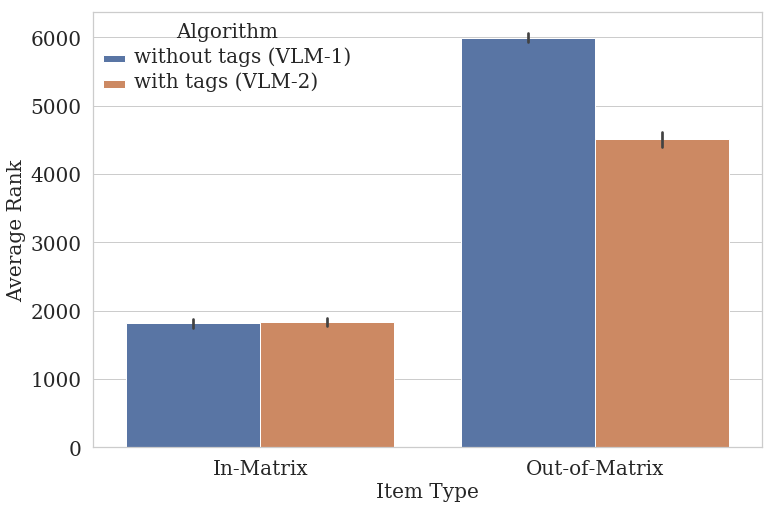

In [291]:
fig1 = plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Item Type", y="Average Rank", hue = 'Algorithm', data=video_playcount_mrr_df)
ax.set_xlabel('Item Type', fontsize=20);
ax.set_ylabel('Average Rank', fontsize = 20);
ax.set_xticklabels(['In-Matrix', 'Out-of-Matrix'], fontsize = 20);
ax.set_yticklabels(np.arange(0, 20000, 1000), fontsize = 20);
plt.setp(ax.get_legend().get_texts(), fontsize='20'); # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20'); # for legend title

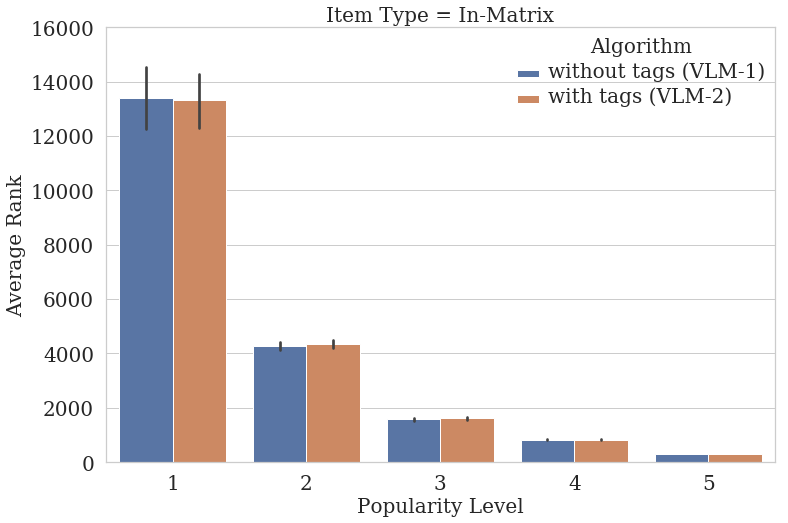

In [283]:
fig1 = plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Popularity Level", y="Average Rank", hue = 'Algorithm',
                 data=video_playcount_mrr_df[video_playcount_mrr_df['availability'] == 1])
ax.set_xlabel('Popularity Level', fontsize=20);
ax.set_ylabel('Average Rank', fontsize = 20);
ax.set_xticklabels([1, 2, 3, 4, 5], fontsize = 20);
ax.set_title('Item Type = In-Matrix', fontsize = 20);
ax.set_yticks(np.arange(0, 18000, 2000));
ax.set_yticklabels(np.arange(0, 18000, 2000), fontsize = 20);
plt.setp(ax.get_legend().get_texts(), fontsize='20'); # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20'); # for legend title

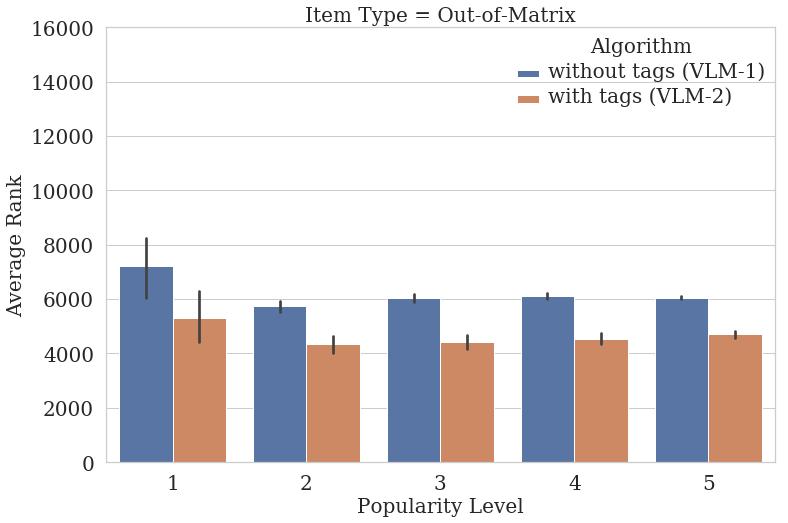

In [284]:
fig1 = plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Popularity Level", y="Average Rank", hue = 'Algorithm',
                 data=video_playcount_mrr_df[video_playcount_mrr_df['availability'] == 0])
ax.set_xlabel('Popularity Level', fontsize=20);
ax.set_ylabel('Average Rank', fontsize = 20);
ax.set_title('Item Type = Out-of-Matrix', fontsize = 20);
ax.set_xticklabels([1, 2, 3, 4, 5], fontsize = 20);
ax.set_yticks(np.arange(0, 18000, 2000));
ax.set_yticklabels(np.arange(0, 18000, 2000), fontsize = 20);
plt.setp(ax.get_legend().get_texts(), fontsize='20'); # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20'); # for legend title

In [241]:
video_playcount_mrr_df['Average Rank'] = video_playcount_mrr_df['ranks']

<Figure size 1008x1368 with 0 Axes>

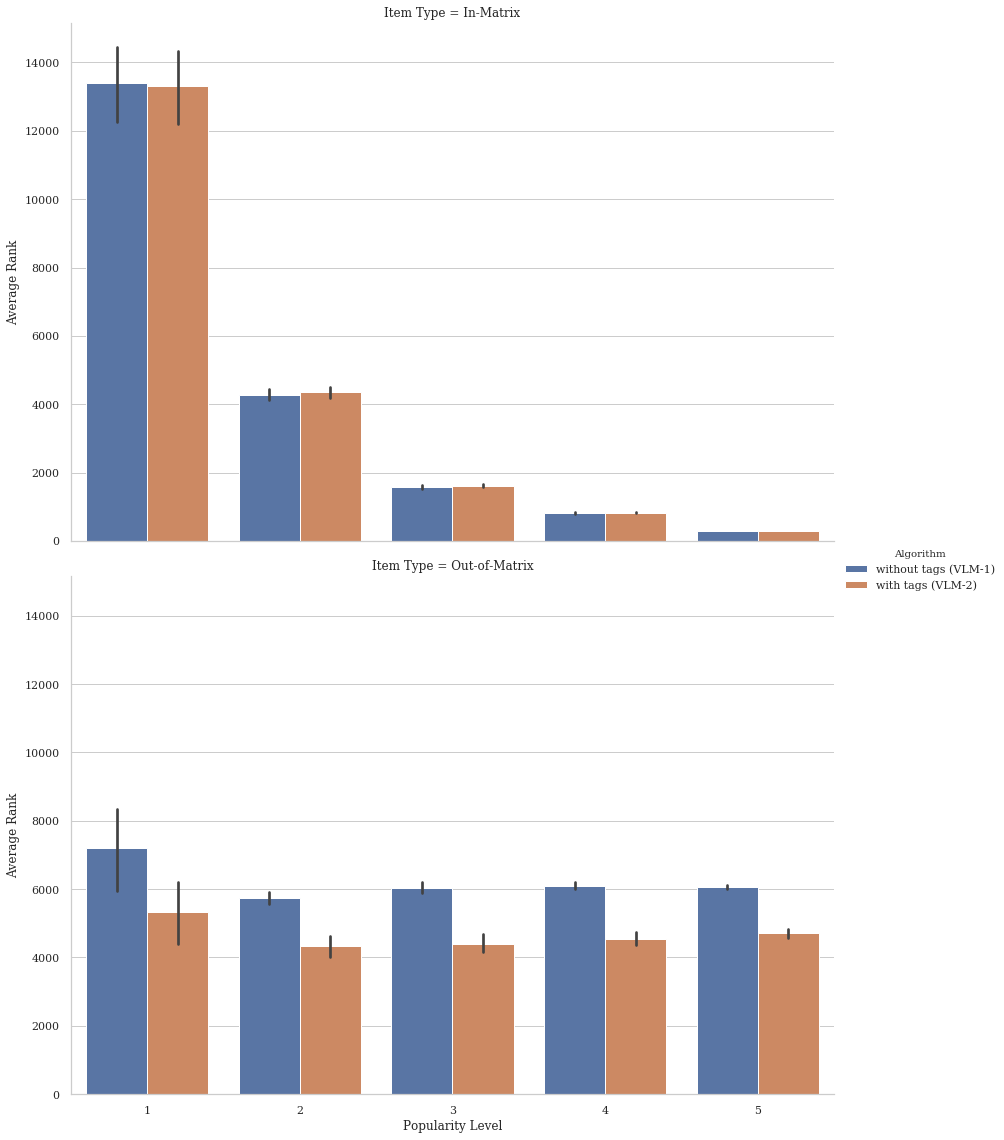

In [269]:
fig1 = plt.figure(figsize=(14, 19));
ax = sns.catplot(x="Popularity Level", y="Average Rank", hue = 'Algorithm',
                 row = 'Item Type', kind="bar",
                 height = 8,
                 aspect = 1.5,
                 data=video_playcount_mrr_df);
#ax.set_xlabel('Item Type', fontsize=20);
#ax.set_ylabel('Average Rank', fontsize = 20);
#ax.set_xticklabels(['out-of-matrix', 'in-matrix'], fontsize = 20);
#ax.set_yticklabels(np.arange(0, 20000, 1000), fontsize = 20);
#plt.setp(ax.get_legend().get_texts(), fontsize='20'); # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='20'); # for legend title

<Figure size 1008x576 with 0 Axes>

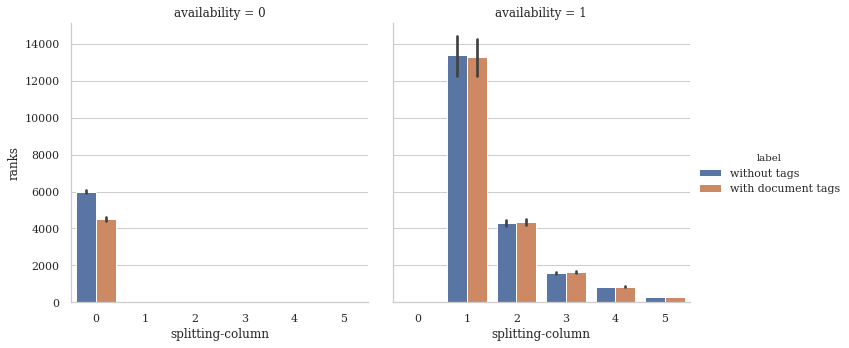

In [223]:
fig1 = plt.figure(figsize=(14, 8))
ax = sns.catplot(x="splitting-column", y="ranks", hue = 'label',
                 col = 'availability',kind="bar",
                 data=video_playcount_mrr_df, sharex=False)